In [1]:
# package(s) related to time, space and id
import datetime

# Used for mathematical functions
import math
import platform
import time

import matplotlib.pyplot as plt

# Used for making the graph to visualize our problem
import networkx as nx

# package(s) for data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import itertools
import tqdm

import plotly.express as px
from plotly.subplots import make_subplots
# spatial libraries
import pyproj
import shapely.geometry

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
from simplekml import Kml, Style



In [2]:
# V=ship velocity(VOG) or deep water velocity no current velocity was taking into account
# Urel=V+Ur
# Urel= 1/1-exp(4*(1-h/T))
# Am=midship cross section
# Ac=channel cross section
# T=ship draft

In [3]:
V=3
Bc=np.any([100])
h = np.array([2, 2.5, 3, 3.5 ,4, 5.5, 7, 10])
T = np.any([2.75])
r=h/T
print(r)

#Classification of water
for i in range(len(r)):
    if r[i] > 3:
        print(r[i], "not effect on ship")
    elif r[i] <= 3 and r[i]>1.5:
        print(r[i], "visible effect on ship")
    elif r[i] <=1.5 and r[i]>1.2:
        print(r[i], "very significant effect on ships")
    else:
        print(r[i], "water motion dominates ship") 
        
# Blockage coefficient Am/Ac
Bs=11.45
Ls=135
S=Bs*Ls+2*Ls*T
print('S=',S,'m^2')
Am=Bs*T
Ac=Bc*h
Blockage=Am/Ac
for i in range(len(Blockage)):
    if Blockage[i] <= 0.1:
        print("very wide channel Urel=Veff")
    else:
        print("urel=V+Ur") 
    
# Froude number
def get_Frh ():
        return V / np.sqrt(h*9.81)   
Frh = get_Frh () 
print('Frh', Frh)

# Frh<1 subcritical dn > dcritical
# Frh>1 supercritical dn < dcritical
def subcritical_or_supercritical (Frh):
    """Check flow"""
    if  np.all(Frh)<1:
        return "subcritical" 
    if  np.all(Frh)<0.65: 
        return"desirable condition"
    if  np.all(Frh)>1: # supercritical flow 
        return "unstable"
    print(subcritical_or_supercritical)
    return
Flow_type = subcritical_or_supercritical (Frh)
print (Flow_type)

# Return flow velocity
def get_Ur ():  
    return (Blockage * V)/(1-(Blockage)-(Frh**2))
Ur = get_Ur ()
print('Ur=', Ur, 'm/s')

# Effective velocity
def get_Veff (): 
    return V/(1-np.exp(4*(1- r)))
Veff = get_Veff ()
print('Veff=', Veff, 'm/s') 

# Relative velocity
def get_Urel ():
    if np.all(Blockage) <=0.1:
        Urel= Veff
    else:
        Urel=  V + Ur
    return Urel
Urel = get_Urel ()
print('Urel=', Urel, 'm/s')

[ 2.   2.5  3.   3.5  4.   5.5  7.  10. ]
2.0 visible effect on ship
2.5 visible effect on ship
3.0 visible effect on ship
3.5 not effect on ship
4.0 not effect on ship
5.5 not effect on ship
7.0 not effect on ship
10.0 not effect on ship
S= 1815.75 m^2
urel=V+Ur
urel=V+Ur
urel=V+Ur
urel=V+Ur
urel=V+Ur
urel=V+Ur
urel=V+Ur
urel=V+Ur
Frh [0.67728546 0.60578253 0.55300126 0.51197969 0.47891314 0.4084185
 0.36202431 0.30289127]
<function subcritical_or_supercritical at 0x000002B648BC3E50>
None
Ur= [ -3.31326048  -3.48114918  -3.66696048  -3.87372614  -4.10520257
  -5.00187028  -6.39970943 -14.5093974 ] m/s
Veff= [3.05597208 3.00745473 3.00100673 3.00013621 3.00001843 3.00000005
 3.         3.        ] m/s
Urel= [ -0.31326048  -0.48114918  -0.66696048  -0.87372614  -1.10520257
  -2.00187028  -3.39970943 -11.5093974 ] m/s


## U_rel calculation and plotting starts from here 
- define function
- set input value
- arrange input table
- use the defined function and get output table
- select desired variables for plotting

#### define function

In [4]:
# Relative velocity
def get_Urel (Bs, Bc, V, T, h):
   
    # get blockage factor
    Am = Bs * T
    Ac = Bc * h
    Blockage = Am / Ac
    
    # get return current speed 
    Frh = V / np.sqrt(h*9.81)
    Ur = (Blockage * V)/(1-(Blockage)-(Frh**2))
    
    # get effective speed     
    r = h/T
    Veff = V/(1-np.exp(4*(1- r)))
    
    if r > 1.5:
        Urel = V 
    else:        
        # get final relative speed to the water 
        if Blockage <= 0.1:
            Urel= Veff
        else:
            Urel=  V + Ur
            
    return Urel


####Rf
def get_Rf (Bs, Bc, V, T, h, Ls):
    # get blockage factor
    Am = Bs * T
    Ac = Bc * h
    Blockage = Am / Ac
    
    # get cf
    Re = (Urel*Ls)/ 10**(-6)
    cf = 0.053 /((np.log10(Re)-2)**2)
    
    Rf = 0.5 *(Urel**2) * cf * (Bs *Ls + 2 * Ls * T)
    return  Rf

####Rp
def get_Rp (Bs, T):
    Rp = 0.5 *(Urel**2) * 0.15 * (Bs * T)
    return Rp

####Rz
def get_Rz (Bs, Bc, T, h, V):
    
    # get blockage factor
    Am = Bs * T
    Ac = Bc * h
    Blockage = Am / Ac
    
    # get Froude number
    Frh = V / np.sqrt(h*9.81)
    
    #get z
    z = (Blockage/(1-Blockage-(Frh**2))) * (Frh**2) * h
    
    Rz = 9.81 *z * 0.2 * (Bs * T)
    return z,Rz

####Rtot
def get_Rtot(Rp, Rf, Rz):
    
    Rtot =  Rp + Rf + Rz
    return Rtot

# Power estimation 
# BHP > DHP > EHP
# 1) Effective horse power Pe (Power needed to overcome the total drag)
def get_Pe ():
    Pe = Urel * Rtot
    return Pe

# 2) Delivered horse power Pd (Power delivered to the propeller shaft)
def get_Pd (Pe):
    Pd = Pe/ 0.55
    return Pd

# 3) Brake horse power or Propulsion power Pb (Required motor power)
def get_Pb (Pe):
    Pb = 2*Pe
    return Pb

#### input value for Urel

In [5]:
h = np.linspace(4,10,71)  # water depth from 4 m to 10 m is a suitable range for the Ductch waterways 
h_more = np.linspace(4,10,25) #linspace command to 29 deixnei posa items generate between the range 4-10
V_more = np.linspace(0,5,21)
Bs = [11.4]
Bc= [300] 
V = [3]
T = [2.75]
Ls = [135]

#### prepare input matrix for calculation

In [6]:
h_more = np.linspace(4,10,25)
h_more

array([ 4.  ,  4.25,  4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,
        6.25,  6.5 ,  6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,
        8.5 ,  8.75,  9.  ,  9.25,  9.5 ,  9.75, 10.  ])

In [7]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product( h_more, Bs, Bc, V_more, T, Ls))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"h_more": item[0],"Bs": item[1], "Bc": item[2], "V_more": item[3], "T": item[4], "Ls": item[5]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.head(100)

,h_more,Bs,Bc,V_more,T,Ls
0,4.0,11.4,300,0.00,2.75,135
1,4.0,11.4,300,0.25,2.75,135
2,4.0,11.4,300,0.50,2.75,135
3,4.0,11.4,300,0.75,2.75,135
4,4.0,11.4,300,1.00,2.75,135
...,...,...,...,...,...,...
95,5.0,11.4,300,2.75,2.75,135
96,5.0,11.4,300,3.00,2.75,135
97,5.0,11.4,300,3.25,2.75,135
98,5.0,11.4,300,3.50,2.75,135


#### use the defined function and get output table

In [8]:

results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    h = row['h_more']
    Bs = row['Bs']
    Bc = row['Bc']
    V = row['V_more']
    T = row['T']
    Ls = row['Ls']

    Urel = get_Urel(Bs, Bc, V, T, h)
    Rf = get_Rf(Bs, Bc, V, T, h, Ls)
    Rp = get_Rp(Bs, T)
    (z,Rz) = get_Rz (Bs, Bc, T, h, V)
    Rtot = get_Rtot(Rp, Rf, Rz)
    Pe = get_Pe ()
    Pb = get_Pb (Pe)
    Pd = get_Pd (Pe)


        
    result = {}
    result.update(row)

    result['Urel'] = Urel
    result['Rf'] = Rf
    result['Rp'] = Rp
    result['Rz'] = Rz
    result['z'] = z
    result['Rtot']= Rtot
    result['Pe'] = Pe
    result['Pb'] = Pb
    result['Pd'] = Pd

    results.append(result)

plot_df = pd.DataFrame(results)

plot_df.head(500)

0it [00:00, ?it/s]C:\Users\30698\AppData\Local\Temp\ipykernel_113360\3741552455.py:38: RuntimeWarning: divide by zero encountered in log10
  cf = 0.053 /((np.log10(Re)-2)**2)
525it [00:00, 11265.55it/s]


,h_more,Bs,Bc,V_more,T,Ls,Urel,Rf,Rp,Rz,z,Rtot,Pe,Pb,Pd
0,4.00,11.4,300.0,0.00,2.75,135.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,4.00,11.4,300.0,0.25,2.75,135.0,0.298444,0.171399,0.209422,0.010530,0.000171,0.391351,0.116796,0.233593,0.212357
2,4.00,11.4,300.0,0.50,2.75,135.0,0.596887,0.617491,0.837690,0.042326,0.000688,1.497507,0.893843,1.787685,1.625168
3,4.00,11.4,300.0,0.75,2.75,135.0,0.895331,1.310072,1.884802,0.096025,0.001561,3.290898,2.946442,5.892884,5.357167
4,4.00,11.4,300.0,1.00,2.75,135.0,1.193774,2.236204,3.350759,0.172718,0.002808,5.759680,6.875757,13.751514,12.501377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,9.75,11.4,300.0,3.00,2.75,135.0,3.000000,12.463512,21.161250,0.675629,0.010984,34.300391,102.901172,205.802343,187.093039
496,9.75,11.4,300.0,3.25,2.75,135.0,3.250000,14.474612,24.835078,0.807664,0.013131,40.117355,130.381402,260.762805,237.057095
497,9.75,11.4,300.0,3.50,2.75,135.0,3.500000,16.625616,28.802812,0.955889,0.015541,46.384317,162.345110,324.690220,295.172928
498,9.75,11.4,300.0,3.75,2.75,135.0,3.750000,18.915315,33.064453,1.122010,0.018241,53.101778,199.131668,398.263335,362.057577


#### select desired variables for plotting

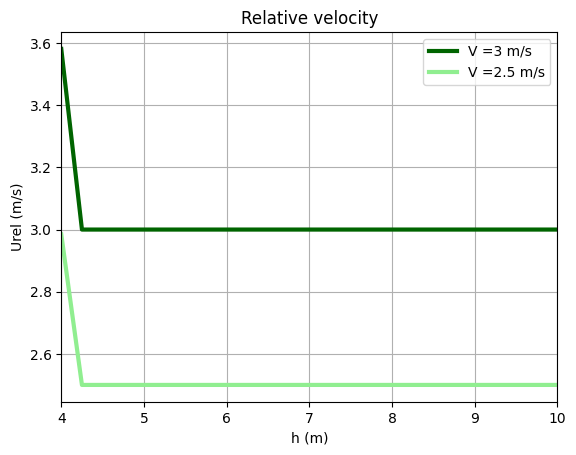

In [9]:
selected_v3 = plot_df.query('V_more == 3')
selected_v2 = plot_df.query('V_more == 2.5')
plt.plot(selected_v3['h_more'], selected_v3['Urel'], 'darkgreen', linewidth = 3.0)
plt.plot(selected_v2['h_more'], selected_v2['Urel'], 'lightgreen', linewidth = 3.0)
plt.xlabel('h (m)')
plt.ylabel('Urel (m/s)')
# δεν εχει οριο στον y  τα καθοριζει μονο του
plt.grid()
plt.xlim(4, 10)
plt.legend(['V =3 m/s','V =2.5 m/s'])
plt.title('Relative velocity');

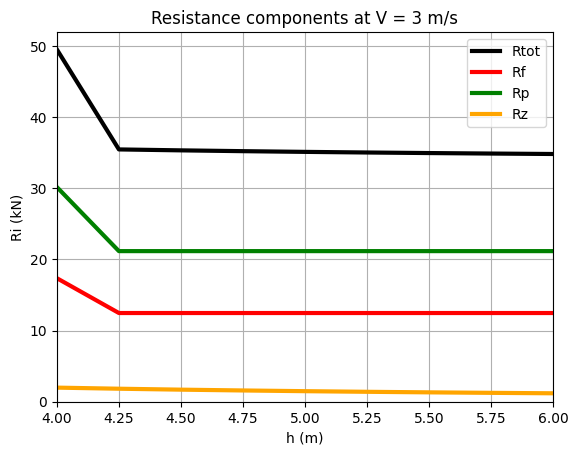

In [10]:
selected = plot_df.query('V_more == 3')



plt.plot(selected['h_more'], selected['Rtot'], 'black', linewidth = 3.0)
plt.plot(selected['h_more'], selected['Rf'], 'red', linewidth = 3.0)
plt.plot(selected['h_more'], selected['Rp'], 'green', linewidth = 3.0)
plt.plot(selected['h_more'], selected['Rz'], 'orange', linewidth = 3.0)
plt.xlabel('h (m)')
plt.ylabel('Ri (kN)')
plt.legend(['Rtot','Rf','Rp','Rz',])
plt.grid()
plt.xlim(4, 6)
plt.ylim(0)
plt.title('Resistance components at V = 3 m/s');

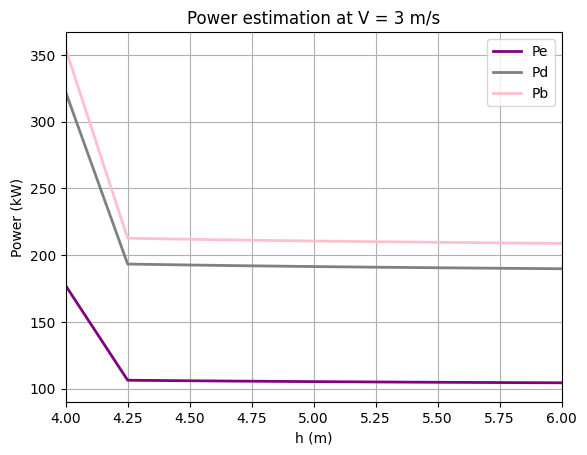

In [11]:
selected = plot_df.query('V_more == 3')


plt.plot(selected['h_more'], selected['Pe'], 'purple', linewidth = 2.0)
plt.plot(selected['h_more'], selected['Pd'], 'gray', linewidth = 2.0)
plt.plot(selected['h_more'], selected['Pb'], 'pink', linewidth = 2.0)

plt.xlabel('h (m)')
plt.ylabel('Power (kW)')
plt.legend(['Pe','Pd','Pb'])
plt.grid()
plt.xlim(4, 6)
plt.ylim()
plt.title('Power estimation at V = 3 m/s');

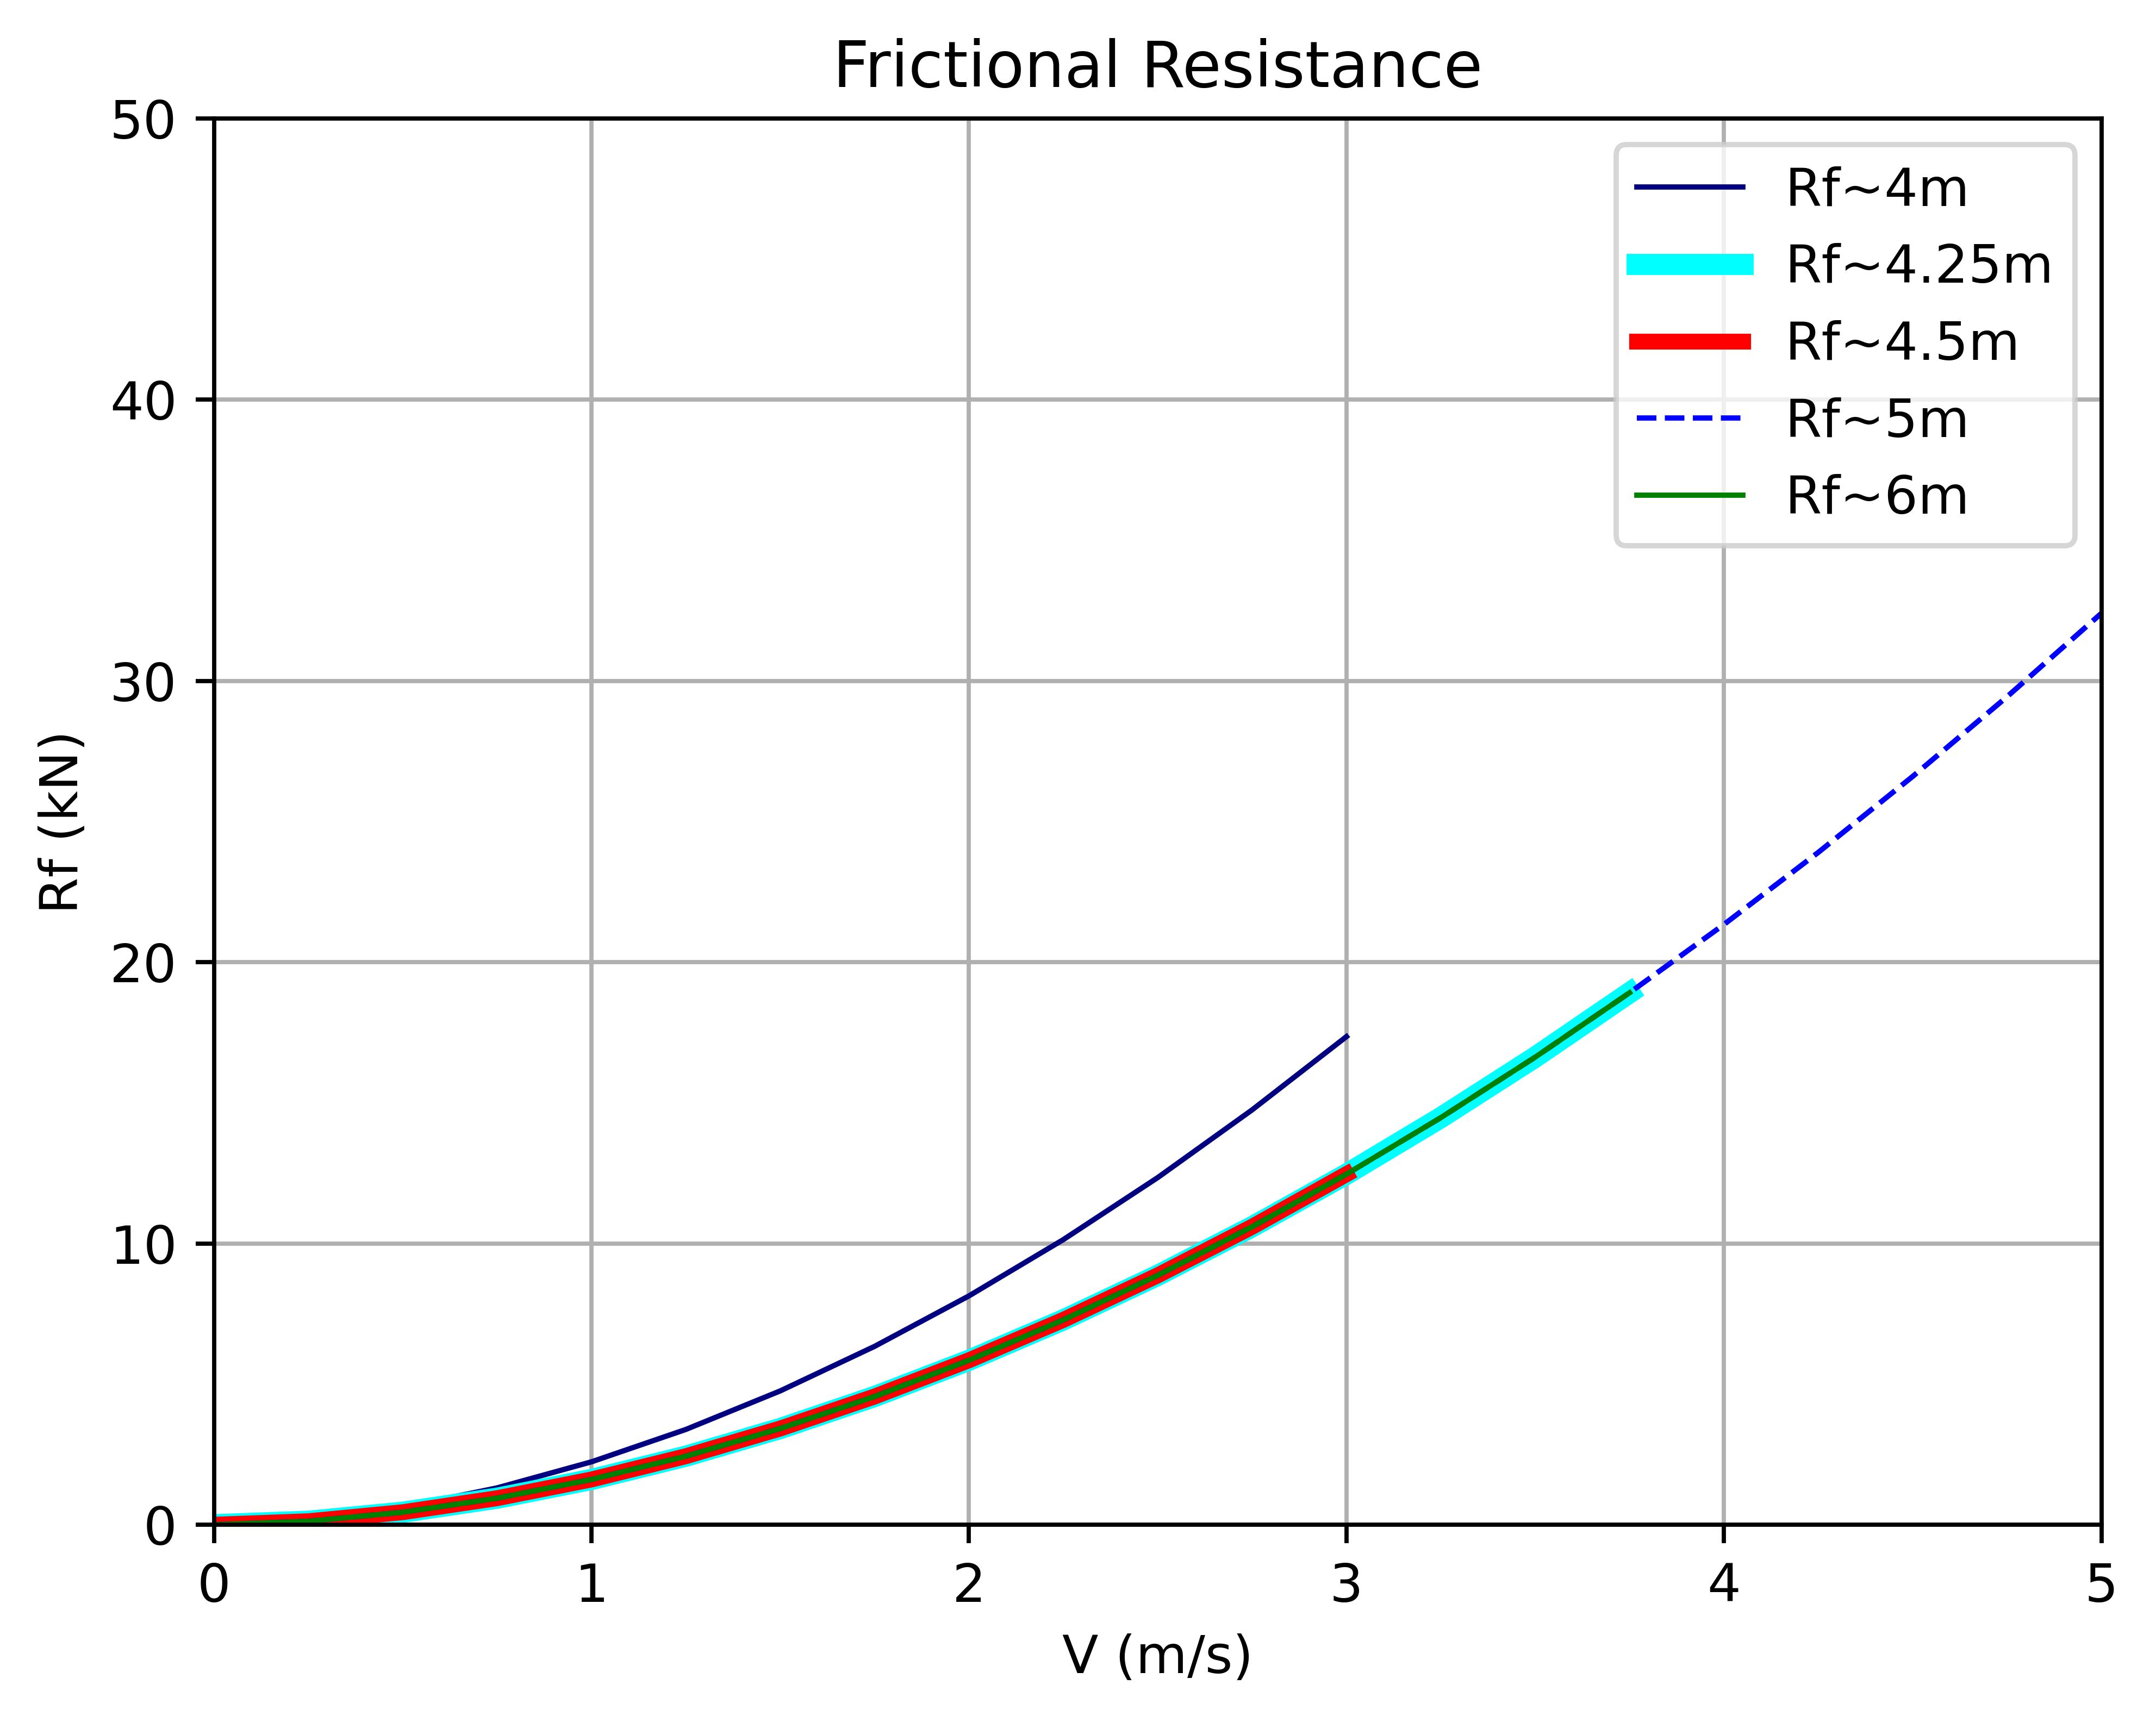

In [12]:
selected_h_4 = plot_df.query('h_more == 4  & V_more <= 3') # βαζεις οριο εως που θες να φτασει η ταχυτητα
selected_h_4_2_5 = plot_df.query('h_more == 4.25  & V_more <= 3.8') 
selected_h_4_5 = plot_df.query('h_more == 4.5  & V_more <= 3')
selected_h_5 = plot_df.query('h_more == 5')
selected_h_6 = plot_df.query('h_more == 6 & V_more <= 3.8')


plt.figure(dpi=700)
plt.plot(selected_h_4['V_more'],selected_h_4['Rf'], 'navy', linewidth = 1.0)
plt.plot(selected_h_4_2_5['V_more'],selected_h_4_2_5['Rf'], 'cyan', linewidth = 4.0)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Rf'], 'r', linewidth = 3.0)
plt.plot(selected_h_5['V_more'],selected_h_5['Rf'], 'blue', linewidth = 1, linestyle = 'dashed')
plt.plot(selected_h_6['V_more'],selected_h_6['Rf'], 'green', linewidth = 1.0)



# plt.plot(plot_df['Urel'], plot_df['Rp'], 'green', linewidth = 3.0)
# plt.plot(plot_df['Urel'], plot_df['Rz'], 'orange', linewidth = 3.0)
# plt.plot(plot_df['Urel'], plot_df['Rtot'], 'black', linewidth = 3.0)
plt.xlabel('V (m/s)')
plt.ylabel('Rf (kN)')
plt.legend(['Rf~4m','Rf~4.25m','Rf~4.5m','Rf~5m','Rf~6m'])
plt.grid()
plt.xlim(0, 5)
plt.ylim(0, 50)
plt.title('Frictional Resistance');

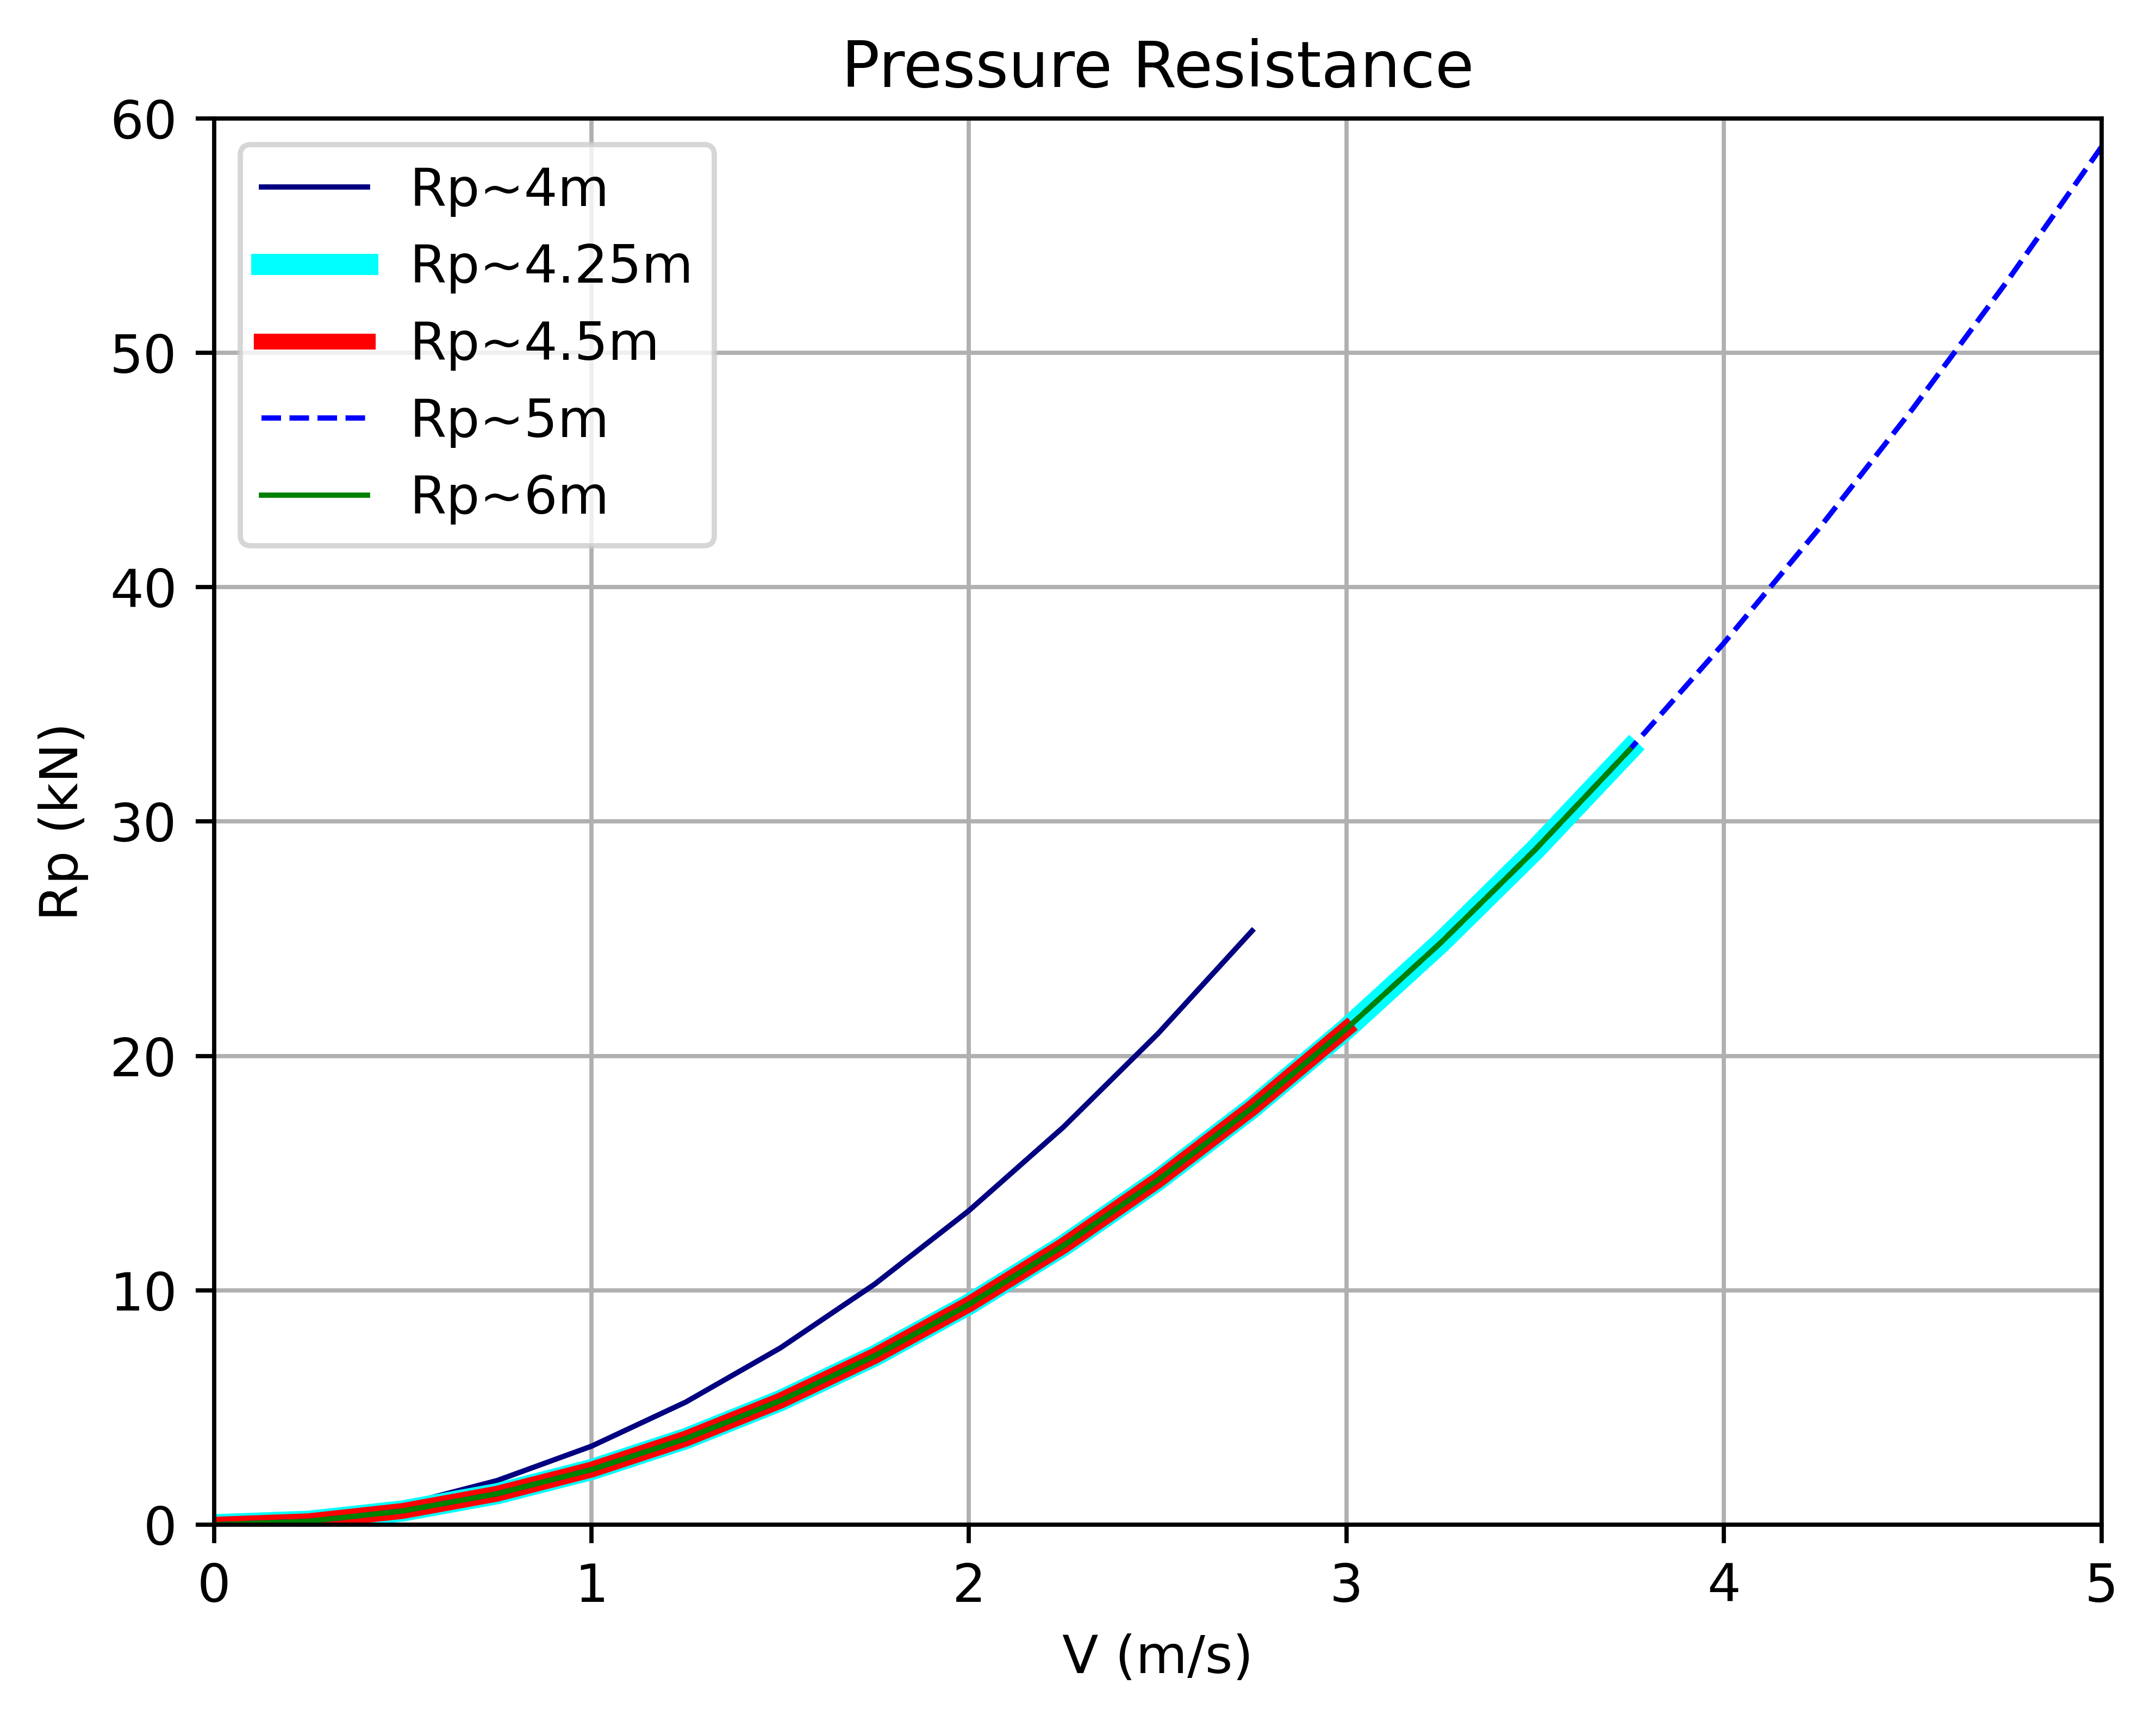

In [13]:
selected_h_4 = plot_df.query('h_more == 4 & V_more < 3')
selected_h_4_2_5 = plot_df.query('h_more == 4.25  & V_more <= 3.8') 
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3')
selected_h_5 = plot_df.query('h_more == 5')
selected_h_6 = plot_df.query('h_more == 6 & V_more <= 3.8')


plt.figure(dpi=700)
plt.plot(selected_h_4['V_more'],selected_h_4['Rp'], 'navy', linewidth = 1.0)
plt.plot(selected_h_4_2_5['V_more'],selected_h_4_2_5['Rp'], 'cyan', linewidth = 4.0)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Rp'], 'r', linewidth = 3.0)
plt.plot(selected_h_5['V_more'],selected_h_5['Rp'], 'blue', linewidth = 1, linestyle = 'dashed')
plt.plot(selected_h_6['V_more'],selected_h_6['Rp'], 'green', linewidth = 1.0)


# plt.plot(plot_df['Urel'], plot_df['Rp'], 'green', linewidth = 3.0)
# plt.plot(plot_df['Urel'], plot_df['Rz'], 'orange', linewidth = 3.0)
# plt.plot(plot_df['Urel'], plot_df['Rtot'], 'black', linewidth = 3.0)
plt.xlabel('V (m/s)')
plt.ylabel('Rp (kN)')
plt.legend(['Rp~4m','Rp~4.25m','Rp~4.5m','Rp~5m','Rp~6m'])
plt.grid()
plt.xlim(0, 5)
plt.ylim(0, 60)
plt.title('Pressure Resistance');

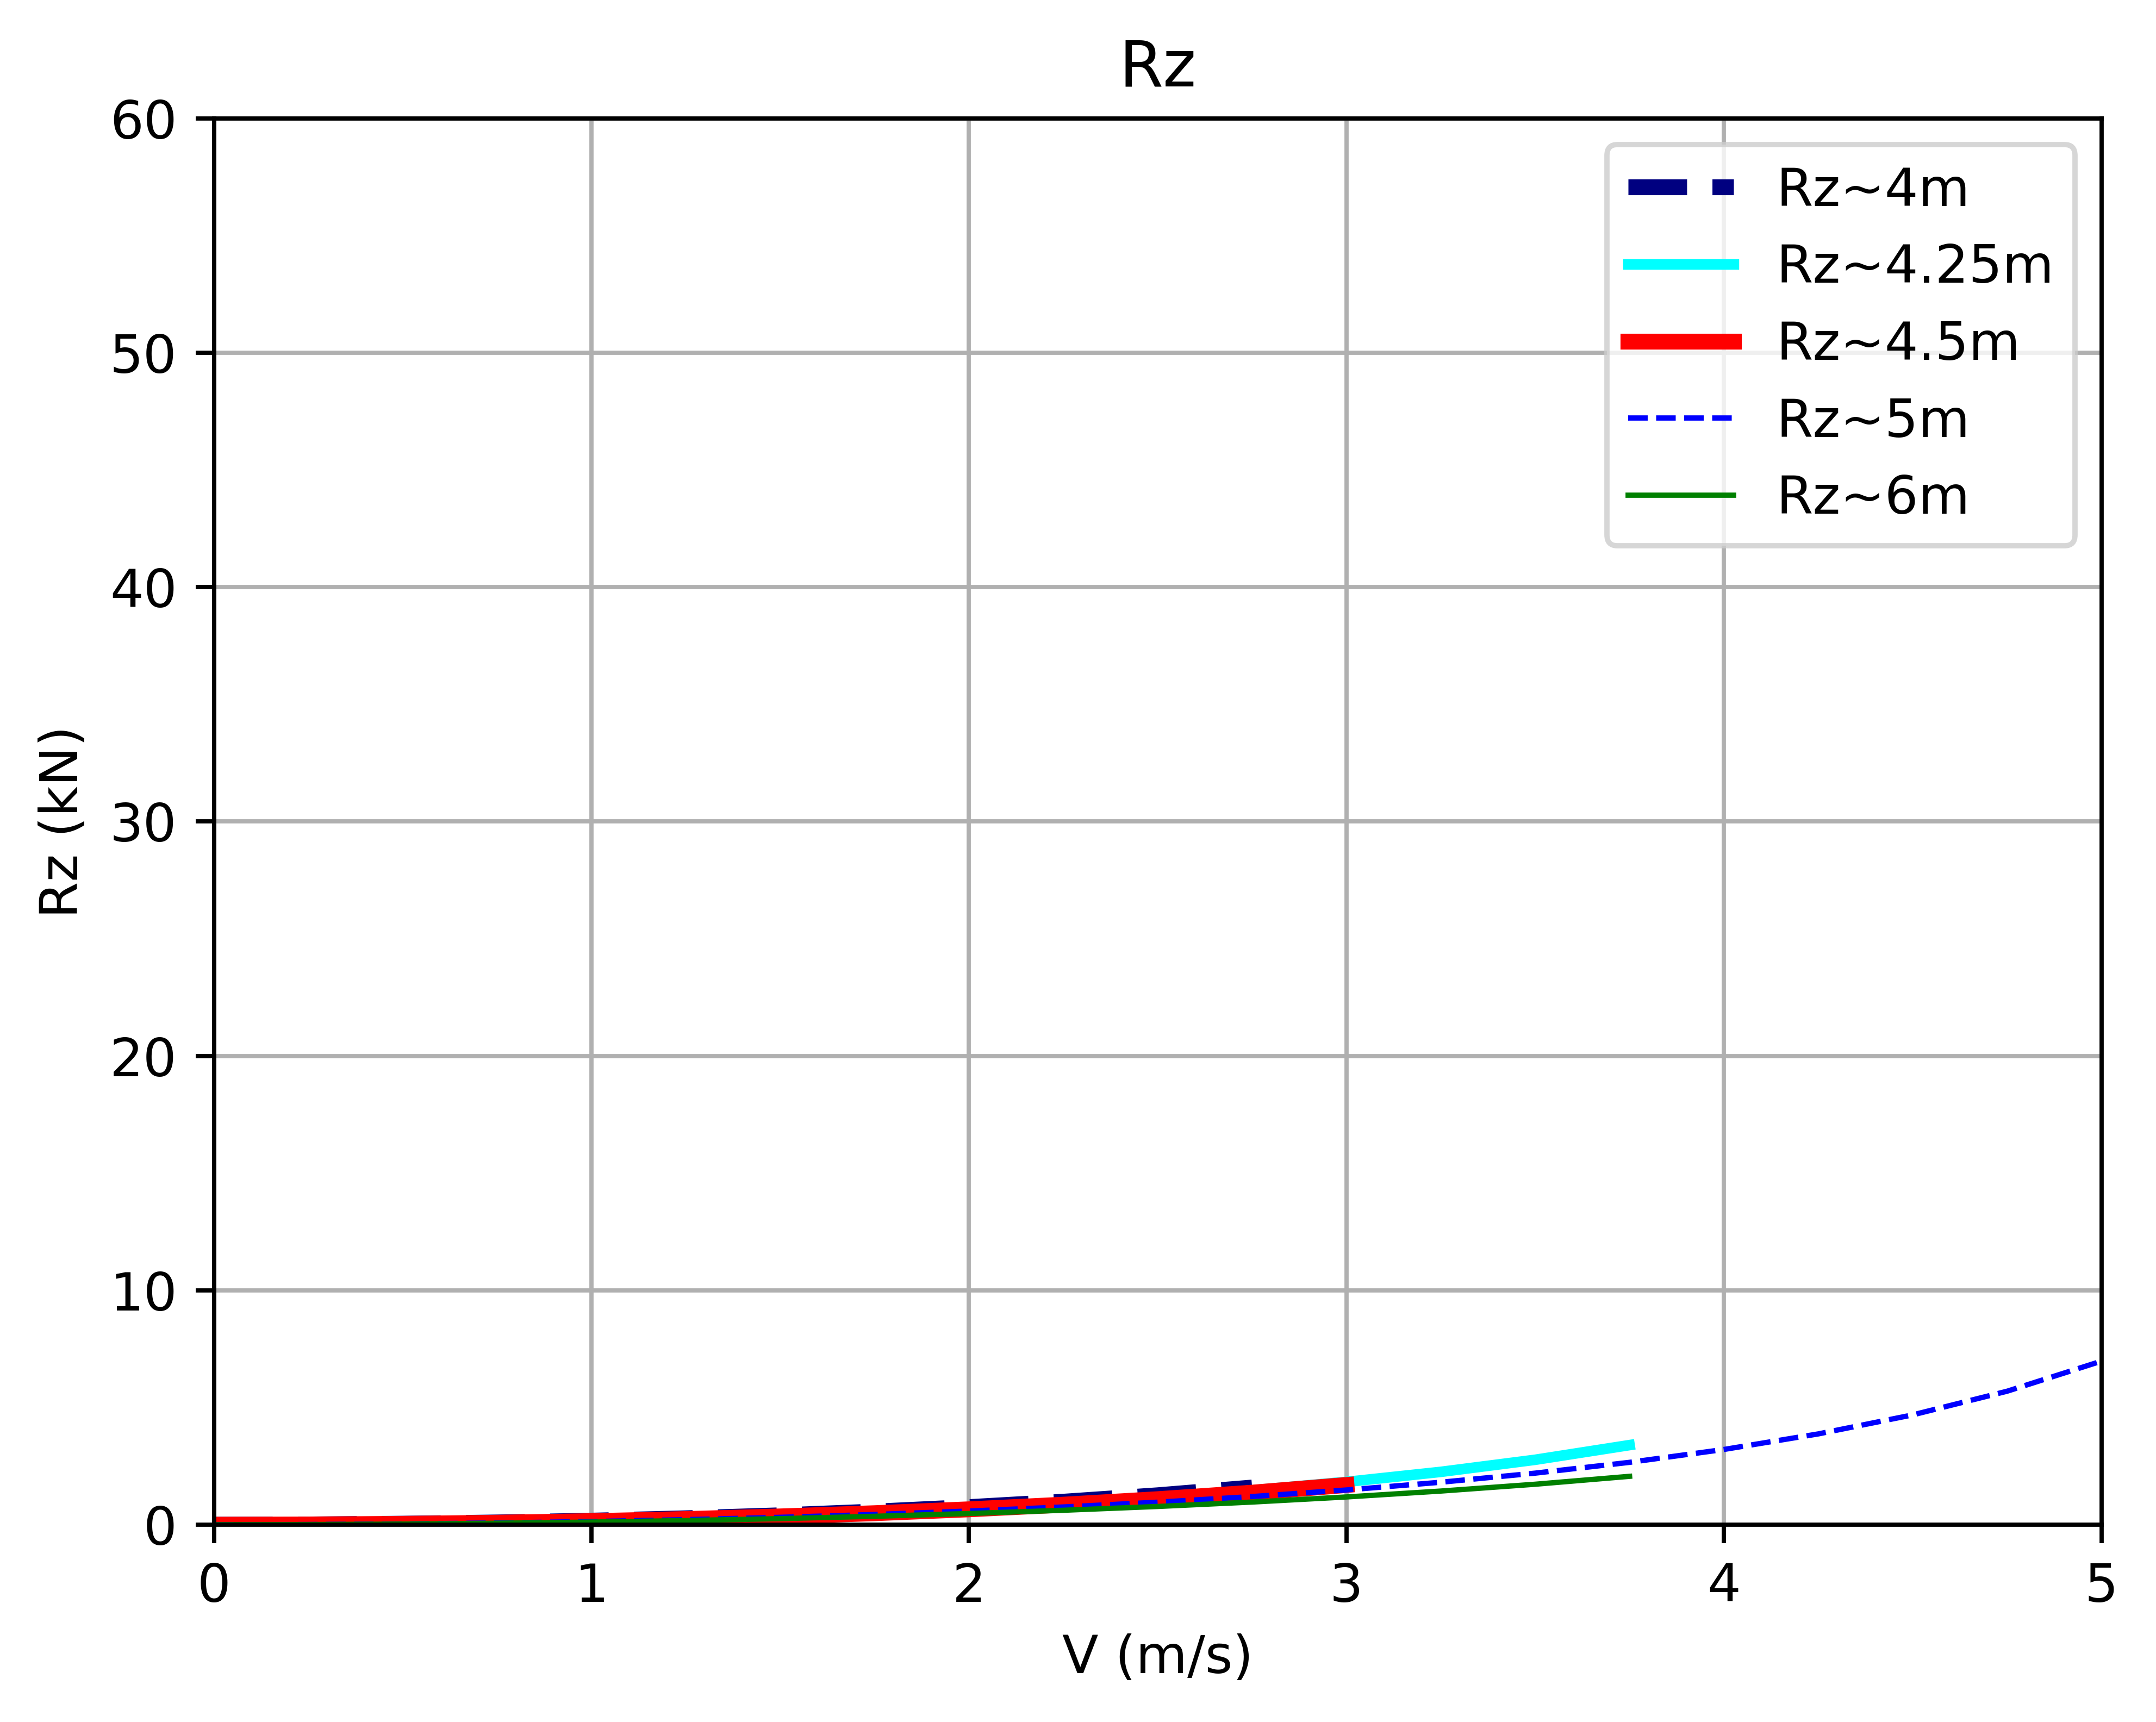

In [14]:
selected_h_4 = plot_df.query('h_more == 4 & V_more < 3')
selected_h_4_2_5 = plot_df.query('h_more == 4.25  & V_more <= 3.8') 
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3')
selected_h_5 = plot_df.query('h_more == 5')
selected_h_6 = plot_df.query('h_more == 6 & V_more <= 3.8')


plt.figure(dpi=700)
plt.plot(selected_h_4['V_more'],selected_h_4['Rz'], 'navy', linewidth = 3.0, linestyle = 'dashed')
plt.plot(selected_h_4_2_5['V_more'],selected_h_4_2_5['Rz'], 'cyan', linewidth = 2.0)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Rz'], 'r', linewidth = 3.0)
plt.plot(selected_h_5['V_more'],selected_h_5['Rz'], 'blue', linewidth = 1, linestyle = 'dashed')
plt.plot(selected_h_6['V_more'],selected_h_6['Rz'], 'green', linewidth = 1.0)


# plt.plot(plot_df['Urel'], plot_df['Rp'], 'green', linewidth = 3.0)
# plt.plot(plot_df['Urel'], plot_df['Rz'], 'orange', linewidth = 3.0)
# plt.plot(plot_df['Urel'], plot_df['Rtot'], 'black', linewidth = 3.0)
plt.xlabel('V (m/s)')
plt.ylabel('Rz (kN)')
plt.legend(['Rz~4m','Rz~4.25m','Rz~4.5m','Rz~5m','Rz~6m'])
plt.grid()
plt.xlim(0, 5)
plt.ylim(0, 60)
plt.title('Rz');

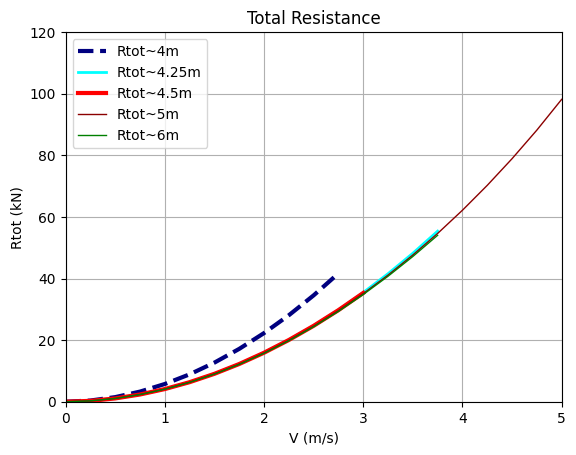

In [15]:
selected_h_4 = plot_df.query('h_more == 4 & V_more < 3')
selected_h_4_2_5 = plot_df.query('h_more == 4.25  & V_more <= 3.8') 
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3')
selected_h_5 = plot_df.query('h_more == 5')
selected_h_6 = plot_df.query('h_more == 6 & V_more <= 3.8')



plt.plot(selected_h_4['V_more'],selected_h_4['Rtot'],'navy', linewidth = 3.0, linestyle = 'dashed')
plt.plot(selected_h_4_2_5['V_more'],selected_h_4_2_5['Rtot'], 'cyan', linewidth = 2.0)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Rtot'], 'r', linewidth = 3.0)
plt.plot(selected_h_5['V_more'],selected_h_5['Rtot'], 'darkred', linewidth = 1.0)
plt.plot(selected_h_6['V_more'],selected_h_6['Rtot'], 'green', linewidth = 1)

# plt.plot(plot_df['Urel'], plot_df['Rp'], 'green', linewidth = 3.0)
# plt.plot(plot_df['Urel'], plot_df['Rz'], 'orange', linewidth = 3.0)
# plt.plot(plot_df['Urel'], plot_df['Rtot'], 'black', linewidth = 3.0)
plt.xlabel('V (m/s)')
plt.ylabel('Rtot (kN)')
plt.legend(['Rtot~4m','Rtot~4.25m','Rtot~4.5m','Rtot~5m','Rtot~6m'])
plt.xlim(0, 5)
plt.ylim(0, 120)
plt.grid()
plt.title('Total Resistance');

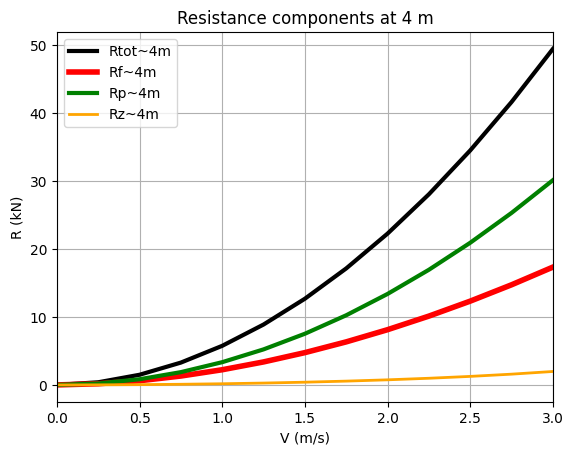

In [16]:
selected_h_4 = plot_df.query('h_more == 4 & V_more <= 3')



plt.plot(selected_h_4['V_more'],selected_h_4['Rtot'], 'black', linewidth = 3.0)
plt.plot(selected_h_4['V_more'],selected_h_4['Rf'], 'red', linewidth = 4.0)
plt.plot(selected_h_4['V_more'],selected_h_4['Rp'], 'green', linewidth = 3.0)
plt.plot(selected_h_4['V_more'],selected_h_4['Rz'], 'orange', linewidth = 2)

plt.xlabel('V (m/s)')
plt.ylabel('R (kN)')
plt.legend(['Rtot~4m','Rf~4m','Rp~4m','Rz~4m'])
plt.grid()
plt.xlim(0, 3)
plt.ylim()
plt.title('Resistance components at 4 m');

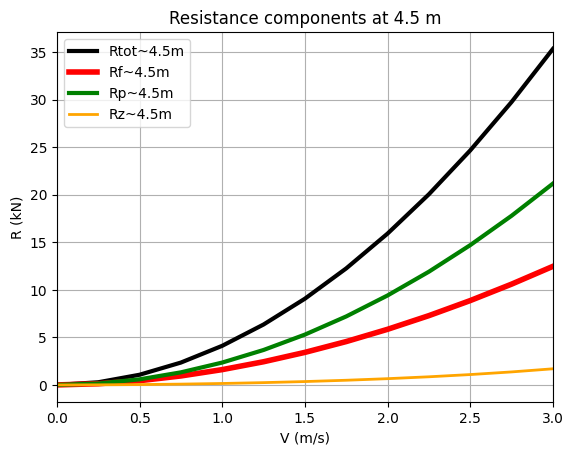

In [17]:
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3')



plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Rtot'], 'black', linewidth = 3.0)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Rf'], 'red', linewidth = 4.0)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Rp'], 'green', linewidth = 3.0)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Rz'], 'orange', linewidth = 2)

plt.xlabel('V (m/s)')
plt.ylabel('R (kN)')
plt.legend(['Rtot~4.5m','Rf~4.5m','Rp~4.5m','Rz~4.5m'])
plt.grid()
plt.xlim(0, 3)
plt.ylim()
plt.title('Resistance components at 4.5 m');

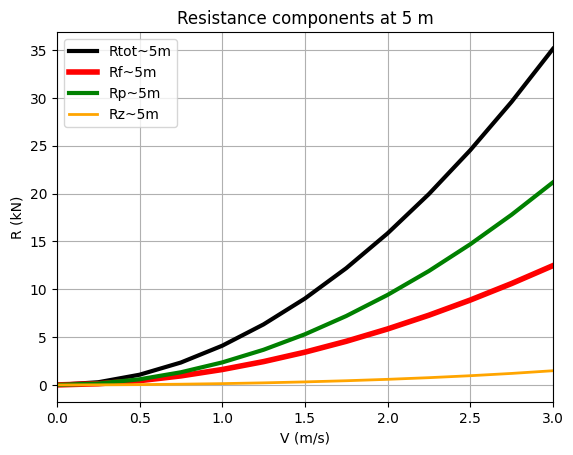

In [18]:
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 3')



plt.plot(selected_h_5['V_more'],selected_h_5['Rtot'], 'black', linewidth = 3.0)
plt.plot(selected_h_5['V_more'],selected_h_5['Rf'], 'red', linewidth = 4.0)
plt.plot(selected_h_5['V_more'],selected_h_5['Rp'], 'green', linewidth = 3.0)
plt.plot(selected_h_5['V_more'],selected_h_5['Rz'], 'orange', linewidth = 2)


plt.xlabel('V (m/s)')
plt.ylabel('R (kN)')
plt.legend(['Rtot~5m','Rf~5m','Rp~5m','Rz~5m'])
plt.grid()
plt.xlim(0, 3)
plt.ylim()
plt.title('Resistance components at 5 m');

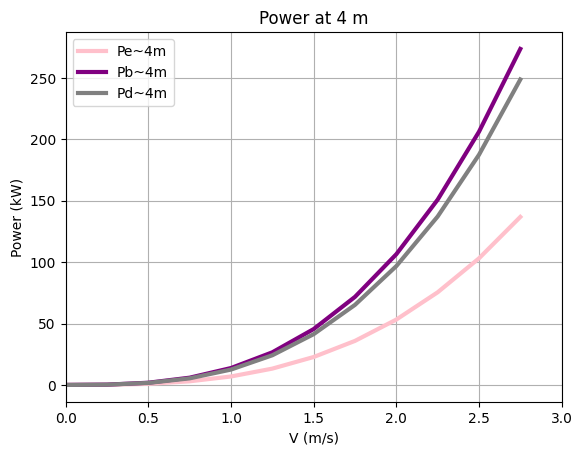

In [19]:
selected_h_4 = plot_df.query('h_more == 4 & V_more < 3')



plt.plot(selected_h_4['V_more'],selected_h_4['Pe'], 'pink', linewidth = 3.0)
plt.plot(selected_h_4['V_more'],selected_h_4['Pb'], 'purple', linewidth = 3.0)
plt.plot(selected_h_4['V_more'],selected_h_4['Pd'], 'gray', linewidth = 3.0)


plt.xlabel('V (m/s)')
plt.ylabel('Power (kW)')
plt.legend(['Pe~4m','Pb~4m','Pd~4m'])
plt.grid()
plt.xlim(0, 3)
plt.ylim()
plt.title('Power at 4 m');

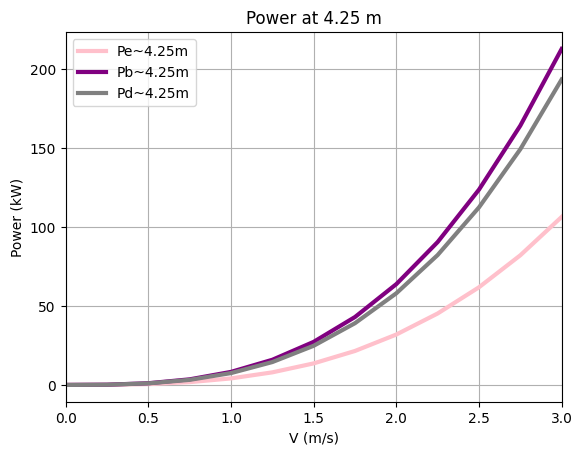

In [20]:
selected_h_4_2_5 = plot_df.query('h_more == 4.25 & V_more <= 3')


plt.plot(selected_h_4_2_5['V_more'],selected_h_4_2_5['Pe'], 'pink', linewidth = 3.0)
plt.plot(selected_h_4_2_5['V_more'],selected_h_4_2_5['Pb'], 'purple', linewidth = 3.0)
plt.plot(selected_h_4_2_5['V_more'],selected_h_4_2_5['Pd'], 'gray', linewidth = 3.0)


plt.xlabel('V (m/s)')
plt.ylabel('Power (kW)')
plt.legend(['Pe~4.25m','Pb~4.25m','Pd~4.25m'])
plt.grid()
plt.xlim(0, 3)
plt.ylim()
plt.title('Power at 4.25 m');

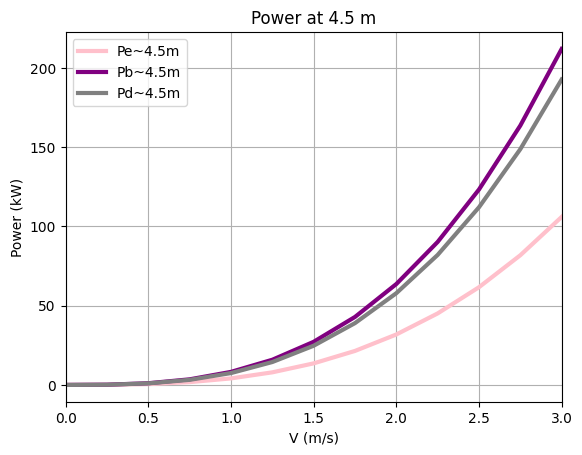

In [21]:
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3')


plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Pe'], 'pink', linewidth = 3.0)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Pb'], 'purple', linewidth = 3.0)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Pd'], 'gray', linewidth = 3.0)


plt.xlabel('V (m/s)')
plt.ylabel('Power (kW)')
plt.legend(['Pe~4.5m','Pb~4.5m','Pd~4.5m'])
plt.grid()
plt.xlim(0, 3)
plt.ylim()
plt.title('Power at 4.5 m');

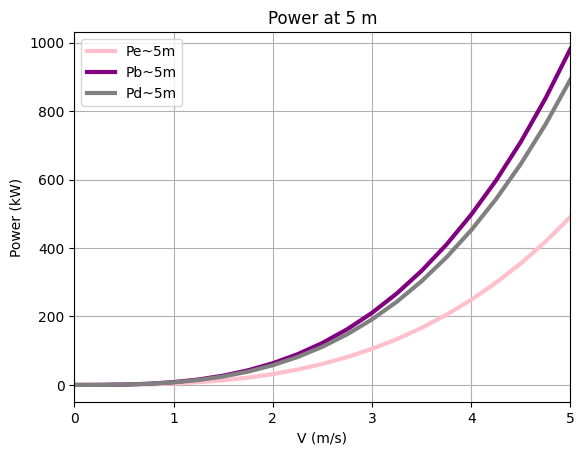

In [22]:
selected_h_5 = plot_df.query('h_more == 5')



plt.plot(selected_h_5['V_more'],selected_h_5['Pe'], 'pink', linewidth = 3.0)
plt.plot(selected_h_5['V_more'],selected_h_5['Pb'], 'purple', linewidth = 3.0)
plt.plot(selected_h_5['V_more'],selected_h_5['Pd'], 'gray', linewidth = 3.0)


plt.xlabel('V (m/s)')
plt.ylabel('Power (kW)')
plt.legend(['Pe~5m','Pb~5m','Pd~5m'])
plt.grid()
plt.xlim(0, 5)
plt.ylim()
plt.title('Power at 5 m');

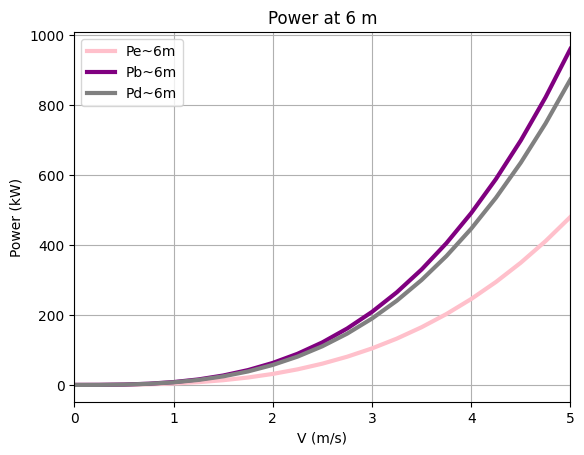

In [23]:
selected_h_6 = plot_df.query('h_more == 6')



plt.plot(selected_h_6['V_more'],selected_h_6['Pe'], 'pink', linewidth = 3.0)
plt.plot(selected_h_6['V_more'],selected_h_6['Pb'], 'purple', linewidth = 3.0)
plt.plot(selected_h_6['V_more'],selected_h_6['Pd'], 'gray', linewidth = 3.0)


plt.xlabel('V (m/s)')
plt.ylabel('Power (kW)')
plt.legend(['Pe~6m','Pb~6m','Pd~6m'])
plt.grid()
plt.xlim(0, 5)
plt.ylim()
plt.title('Power at 6 m');

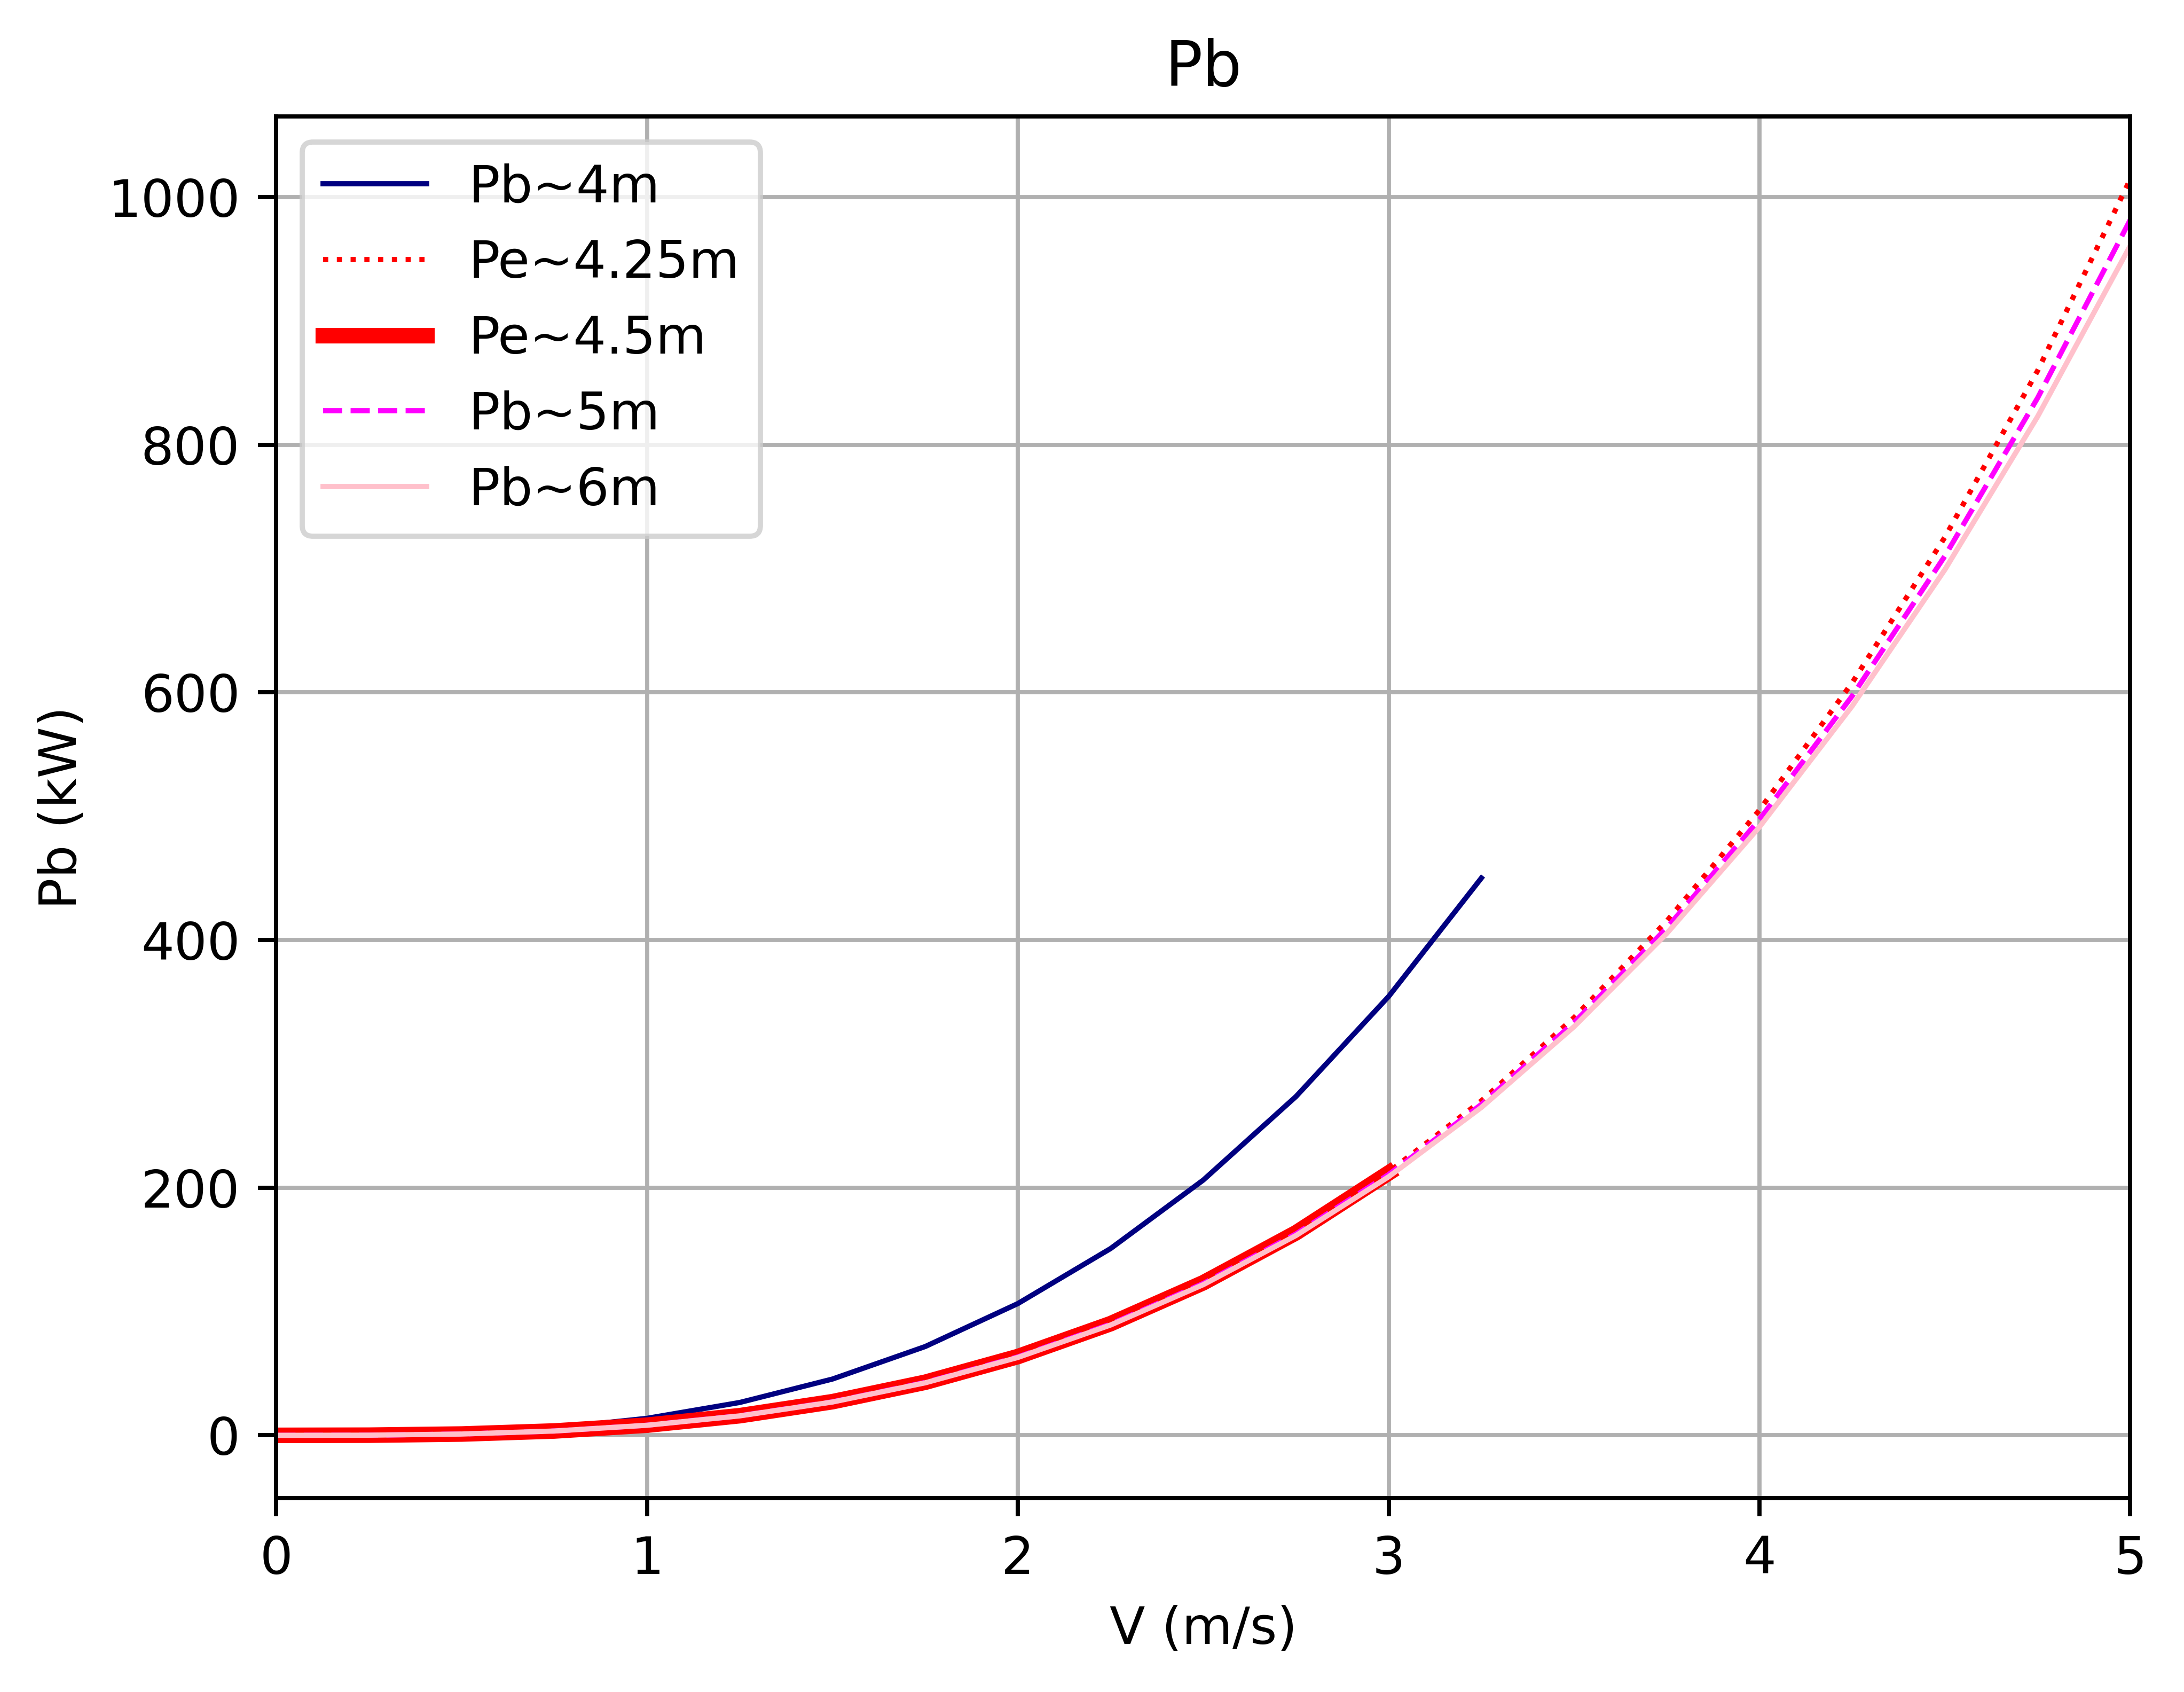

In [24]:
selected_h_4 = plot_df.query('h_more == 4 & V_more < 3.3')
selected_h_4_2_5 = plot_df.query('h_more == 4.25')
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3')
selected_h_5 = plot_df.query('h_more == 5')
selected_h_6 = plot_df.query('h_more == 6')


plt.figure(dpi=700)
plt.plot(selected_h_4['V_more'],selected_h_4['Pb'], 'navy', linewidth = 1.0)
plt.plot(selected_h_4_2_5['V_more'],selected_h_4_2_5['Pb'], 'red', linewidth = 1.0, linestyle = 'dotted')
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Pb'], 'red', linewidth = 3.0)
plt.plot(selected_h_5['V_more'],selected_h_5['Pb'], 'magenta', linewidth = 1.0, linestyle = 'dashed')
plt.plot(selected_h_6['V_more'],selected_h_6['Pb'], 'pink', linewidth = 1)


plt.xlabel('V (m/s)')
plt.ylabel('Pb (kW)')
plt.legend(['Pb~4m','Pe~4.25m','Pe~4.5m','Pb~5m','Pb~6m'])
plt.xlim(0, 5)
plt.ylim()
plt.grid()
plt.title('Pb');

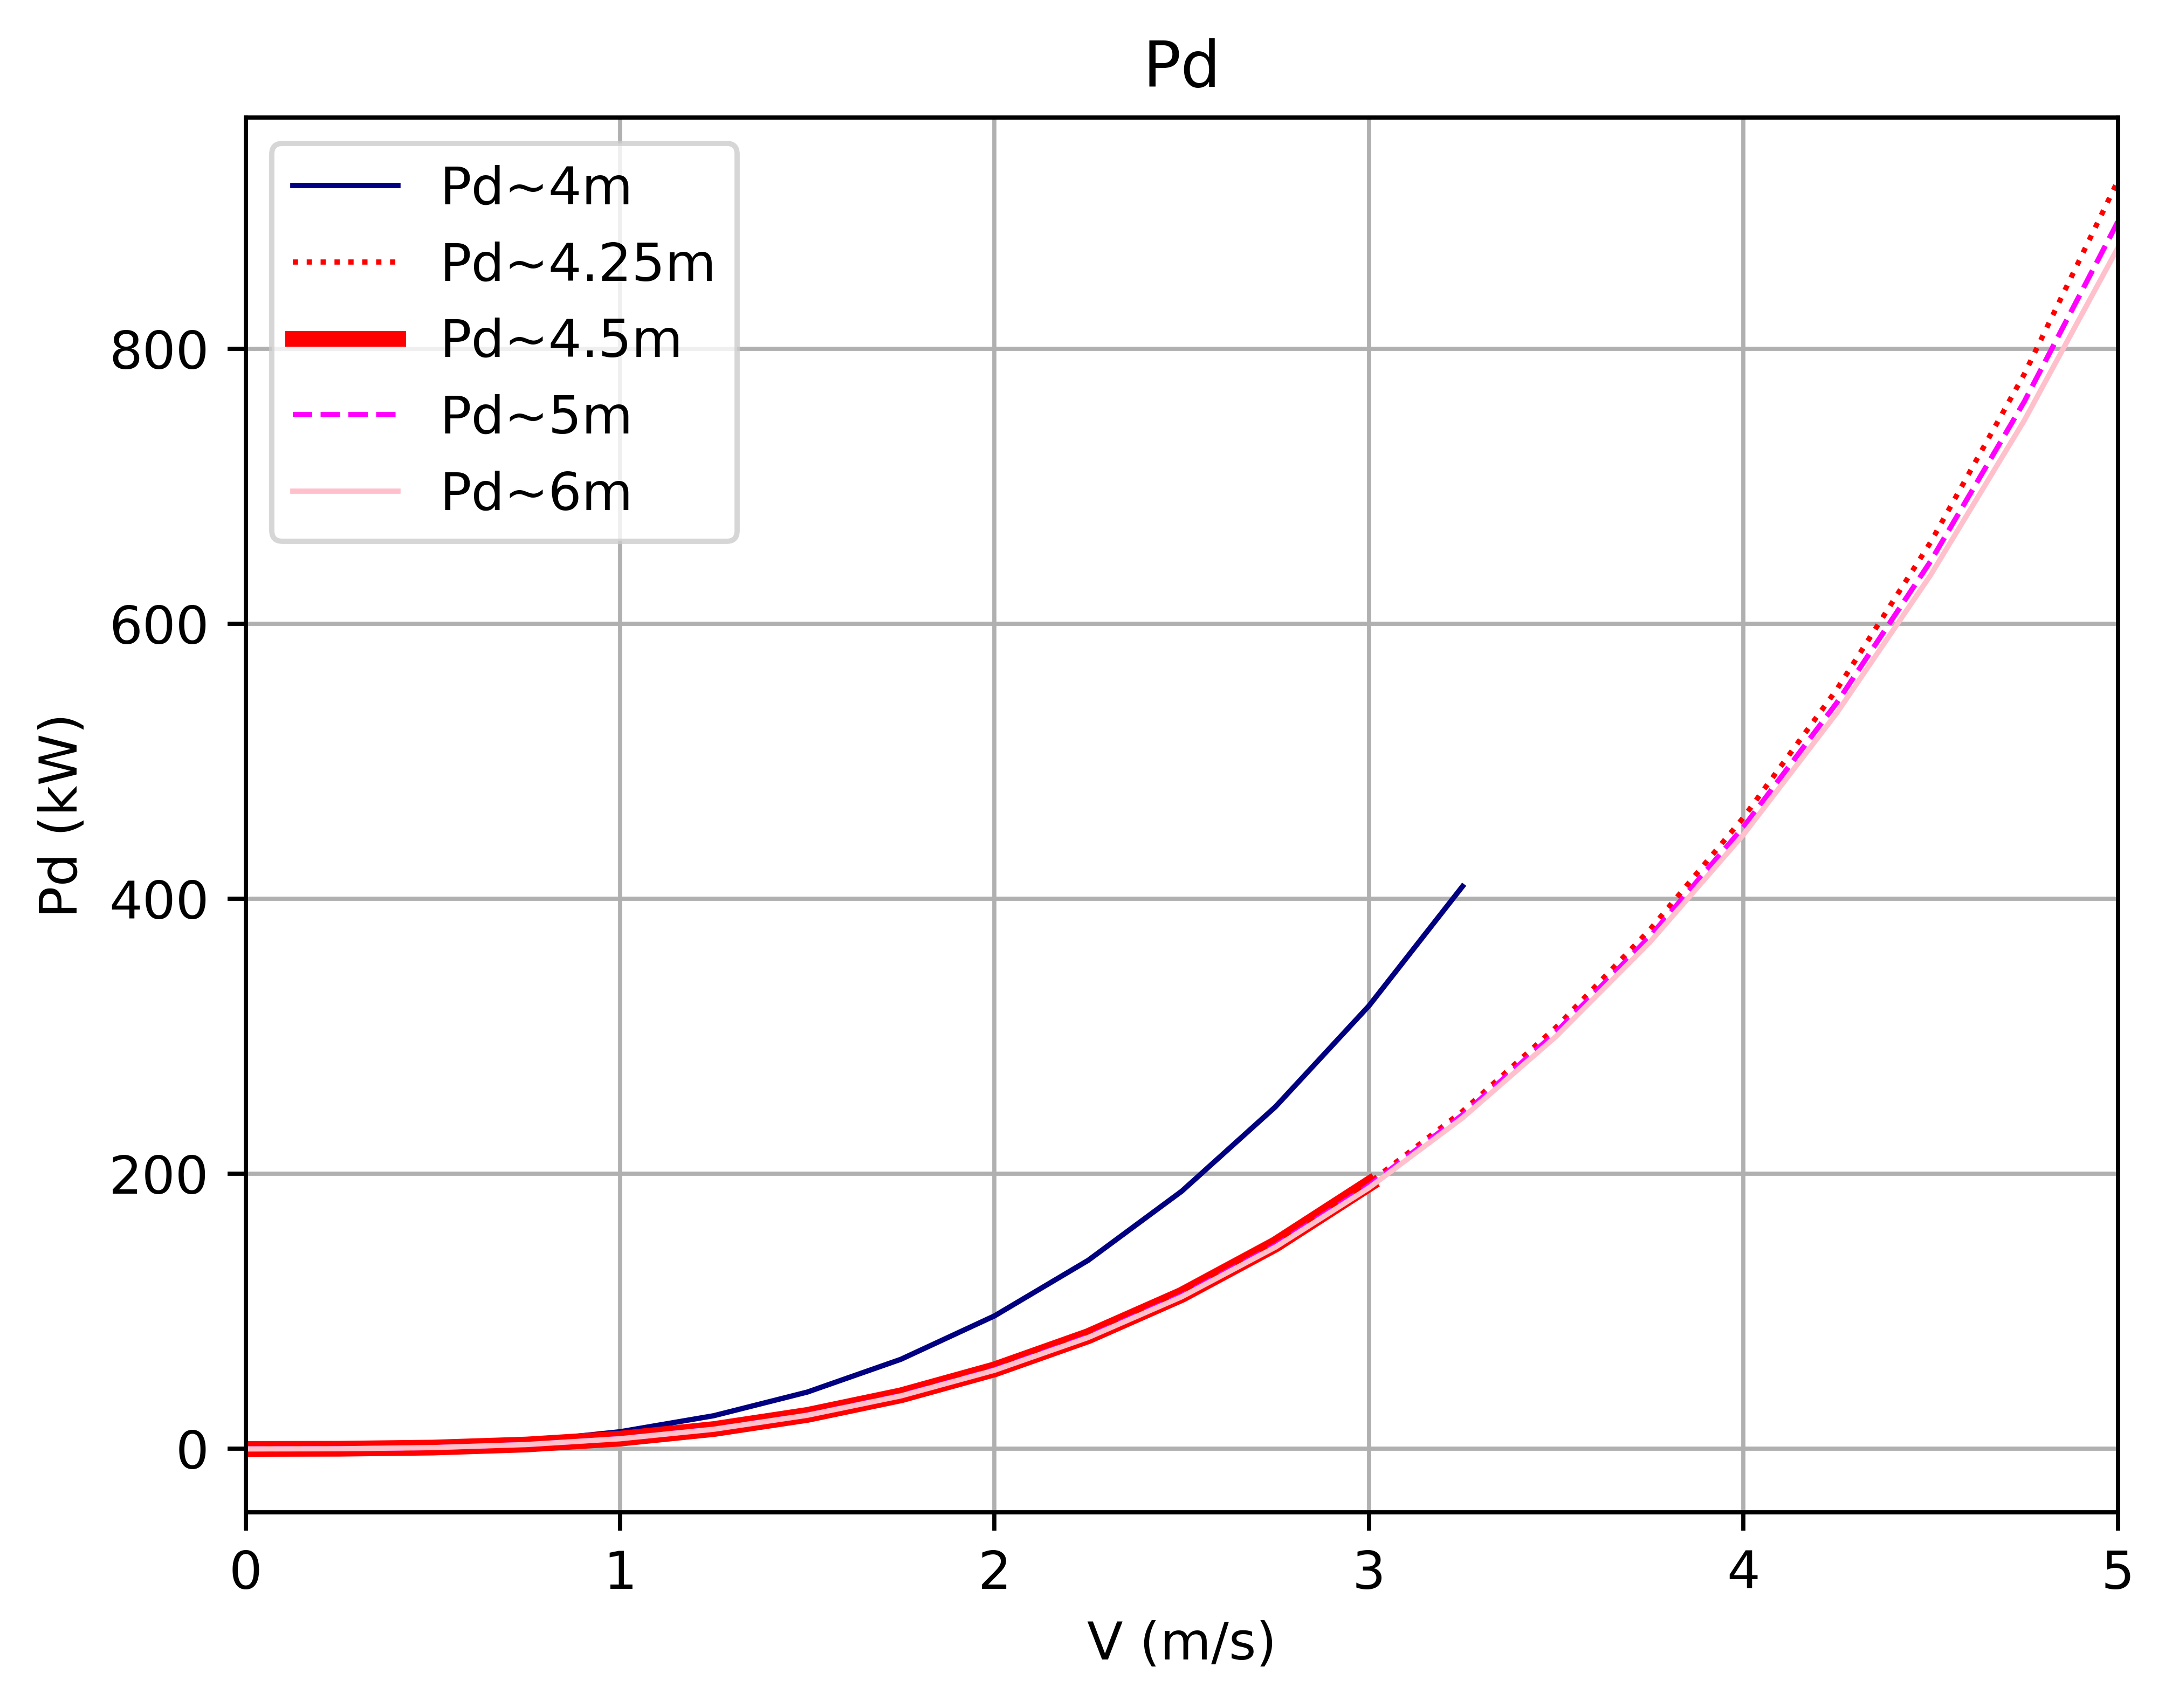

In [25]:
selected_h_4 = plot_df.query('h_more == 4 & V_more < 3.3')
selected_h_4_2_5 = plot_df.query('h_more == 4.25')
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3')
selected_h_5 = plot_df.query('h_more == 5')
selected_h_6 = plot_df.query('h_more == 6')


plt.figure(dpi=700)
plt.plot(selected_h_4['V_more'],selected_h_4['Pd'], 'navy', linewidth = 1.0)
plt.plot(selected_h_4_2_5['V_more'],selected_h_4_2_5['Pd'], 'red', linewidth = 1.0, linestyle = 'dotted')
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Pd'], 'red', linewidth = 3.0)
plt.plot(selected_h_5['V_more'],selected_h_5['Pd'], 'magenta', linewidth = 1.0, linestyle = 'dashed')
plt.plot(selected_h_6['V_more'],selected_h_6['Pd'], 'pink', linewidth = 1)


plt.xlabel('V (m/s)')
plt.ylabel('Pd (kW)')
plt.legend(['Pd~4m','Pd~4.25m','Pd~4.5m','Pd~5m','Pd~6m'])
plt.xlim(0, 5)
plt.ylim()
plt.grid()
plt.title('Pd');

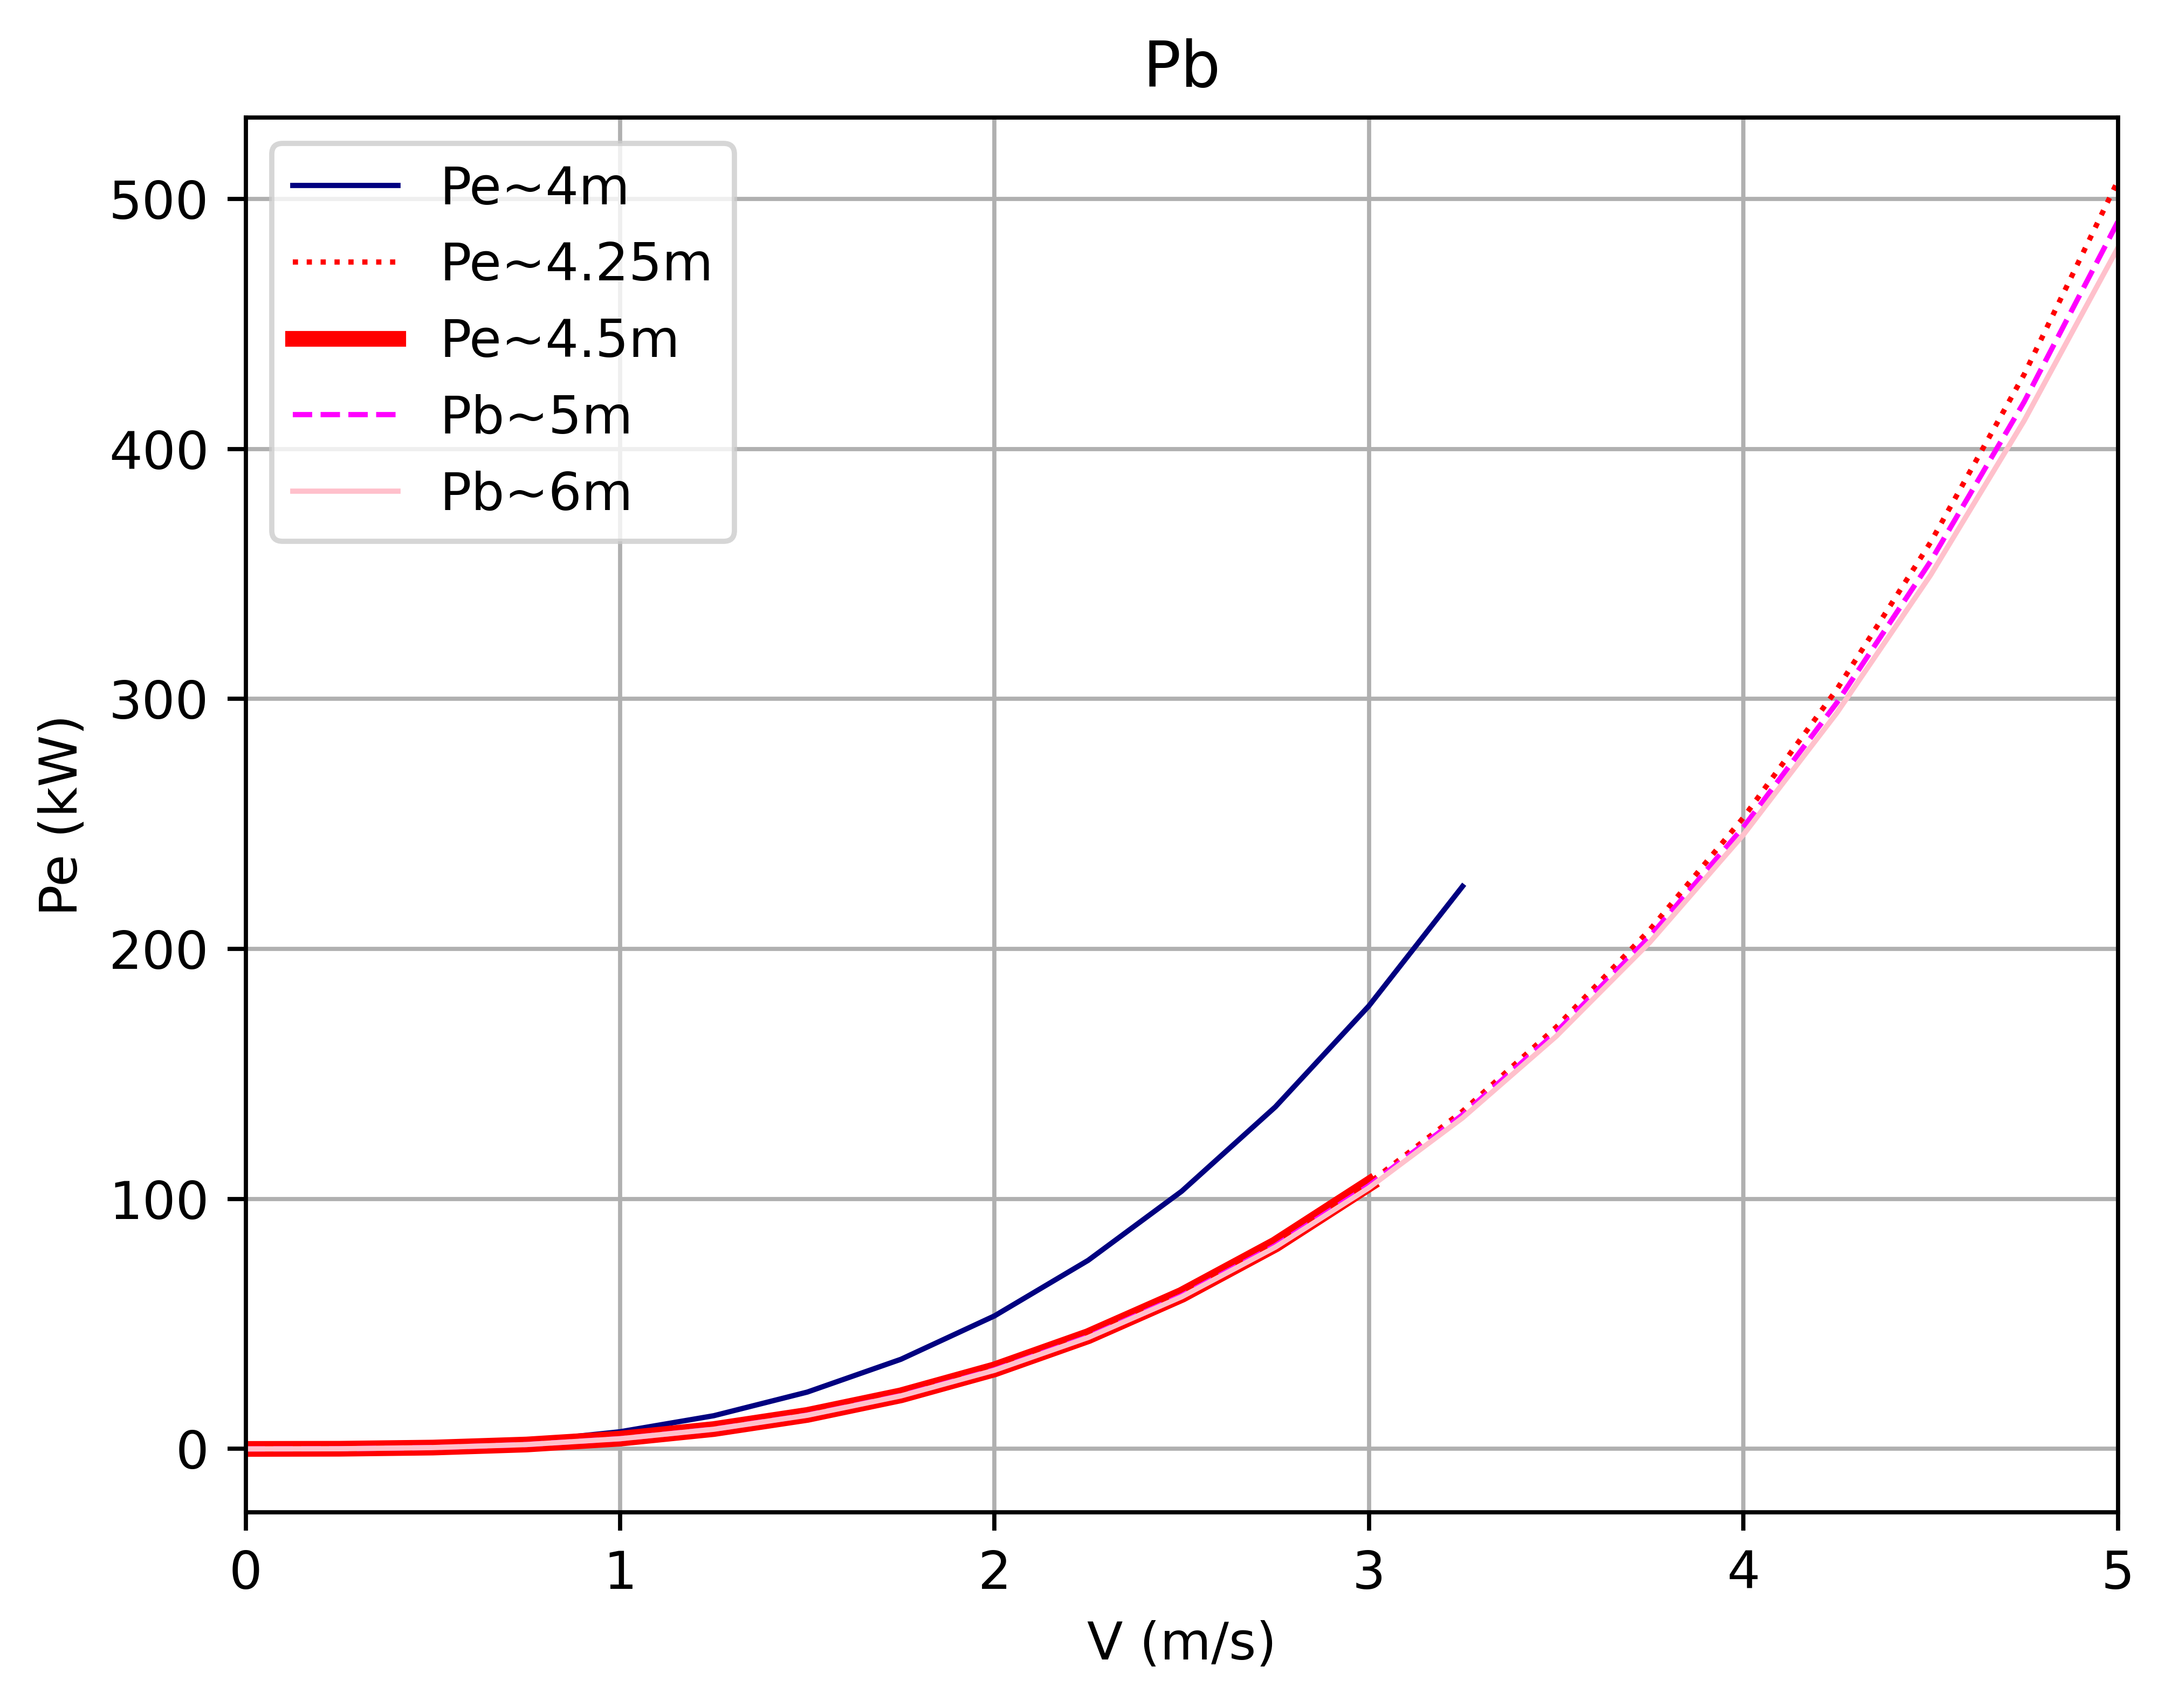

In [26]:
selected_h_4 = plot_df.query('h_more == 4 & V_more < 3.3')
selected_h_4_2_5 = plot_df.query('h_more == 4.25')
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3')
selected_h_5 = plot_df.query('h_more == 5')
selected_h_6 = plot_df.query('h_more == 6')


plt.figure(dpi=700)
plt.plot(selected_h_4['V_more'],selected_h_4['Pe'], 'navy', linewidth = 1.0)
plt.plot(selected_h_4_2_5['V_more'],selected_h_4_2_5['Pe'], 'red', linewidth = 1.0, linestyle = 'dotted')
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Pe'], 'red', linewidth = 3.0)
plt.plot(selected_h_5['V_more'],selected_h_5['Pe'], 'magenta', linewidth = 1.0, linestyle = 'dashed')
plt.plot(selected_h_6['V_more'],selected_h_6['Pe'], 'pink', linewidth = 1)


plt.xlabel('V (m/s)')
plt.ylabel('Pe (kW)')
plt.legend(['Pe~4m','Pe~4.25m','Pe~4.5m','Pb~5m','Pb~6m'])
plt.xlim(0, 5)
plt.ylim()
plt.grid()
plt.title('Pb');